* Данные не обрезаны
* Представление - bag of words
* Очень плохой баланс данных

 Алгоритмы :
* MultinomialNB
* ComplementNB
* LogisticRegression

# Импорт библиотек

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

# Подготовка данных к обучению

Теперь попробуем преобразование bag of words

## Предобработка new

In [10]:
# загрузка
df_new = pd.read_csv('r_dataisbeautiful_posts.csv')

# отображение
df_new.head()

D:\conda\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (5,7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,title,score,author,author_flair_text,removed_by,total_awards_received,awarders,created_utc,full_link,num_comments,over_18
0,hbyv2e,[OC] How Bar Chart Race Animation Can be Creat...,1,Tom10AE,NaN,NaN,0.0,[],1592565317,https://www.reddit.com/r/dataisbeautiful/comme...,0,False
1,hbynoy,[UK] Labour and Conservative vote share by age...,1,Ge0rgeBr0ughton,NaN,NaN,0.0,[],1592564316,https://www.reddit.com/r/dataisbeautiful/comme...,1,False
2,hbym2y,[NOC] Number of wallets returned across the wo...,1,i_am_shattered,NaN,NaN,0.0,[],1592564089,https://www.reddit.com/r/dataisbeautiful/comme...,1,False
3,hbyirw,Largest Banana Producing Countries (1961-2020)...,1,Bilal078692,NaN,moderator,0.0,[],1592563628,https://www.reddit.com/r/dataisbeautiful/comme...,0,False
4,hby1fy,[OC] Popular Combinations for the StamiStudios...,1,shahinrostami,Viz Researcher,NaN,0.0,[],1592561119,https://www.reddit.com/r/dataisbeautiful/comme...,2,False


In [11]:
# очистка от всех признаков кроме title

df_new = df_new.drop(['id', 'score','author','author_flair_text','removed_by','total_awards_received',
             'awarders','created_utc','full_link','num_comments'], axis = 1)
df_new.head()

,title,over_18
0,[OC] How Bar Chart Race Animation Can be Creat...,False
1,[UK] Labour and Conservative vote share by age...,False
2,[NOC] Number of wallets returned across the wo...,False
3,Largest Banana Producing Countries (1961-2020)...,False
4,[OC] Popular Combinations for the StamiStudios...,False


In [12]:
# кол-во записей

len(df_new)

183891

In [13]:
# очистка от null значений

df_new = df_new.dropna()

df_new.head()

,title,over_18
0,[OC] How Bar Chart Race Animation Can be Creat...,False
1,[UK] Labour and Conservative vote share by age...,False
2,[NOC] Number of wallets returned across the wo...,False
3,Largest Banana Producing Countries (1961-2020)...,False
4,[OC] Popular Combinations for the StamiStudios...,False


In [14]:
# кол-во записей после очистки

len(df_new)

183890

## Ещё раз посмотрим на балансировку

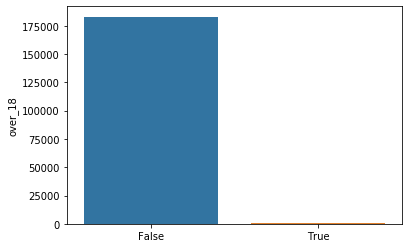

In [15]:
balance = df_new.groupby('over_18')['over_18'].count()

sns.barplot(x = [False, True], y = balance)

## Представим title через bag of words

In [16]:
title_new = df_new['title'].copy()
title_new

0         [OC] How Bar Chart Race Animation Can be Creat...
1         [UK] Labour and Conservative vote share by age...
2         [NOC] Number of wallets returned across the wo...
3         Largest Banana Producing Countries (1961-2020)...
4         [OC] Popular Combinations for the StamiStudios...
                                ...                        
183886             Infosthetics seems like it belongs here.
183887    Time lapse of every nuclear detonation from 19...
183888                                              Wavii. 
183889    An interactive representation of Pres. Obamas ...
183890    A map showing the geographical distribution of...
Name: title, Length: 183890, dtype: object

In [17]:
# импортируем tfidf преобразование
from sklearn.feature_extraction.text import CountVectorizer

# стоп слова
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

# инициализировали алгоритм
vectorizer = CountVectorizer(stop_words=ENGLISH_STOP_WORDS, ngram_range=(1, 2))

# преобразовали в матрицу tfidf 
title_bow = vectorizer.fit_transform(title_new.values)

# отобразим значения 

title_bow[0]

D:\conda\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


<1x647524 sparse matrix of type '<class 'numpy.int64'>'
	with 25 stored elements in Compressed Sparse Row format>

## Выделим целевую переменную

In [18]:
y = np.array([1 if i == True else 0 for i in df_new['over_18']]) # ответы
y

array([0, 0, 0, ..., 0, 0, 0])

## Сделаем train-test split

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(title_bow,
                                                   y,
                                                   test_size=0.2,
                                                   random_state=42)

# Обучение алгоритмов

Как правило, лучше всего с тектсовыми данными из классических алгоритмов справляется Наивный Баес и его модификации. Начнём с него.

Для тюнинга алгоритмов используем кросс-валидацию на тобучающей выборке

In [21]:
# Функция отрисовки графиков
def grid_plot(x, y, x_label, title, y_label='f1'):
    # определили размер графика
    plt.figure(figsize=(12, 6))
    # добавили сетку на фон
    plt.grid(True)
    # построили по х - число соседей, по y - точность
    plt.plot(x, y, 'go-')
    # добавили подписи осей и название графика
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

## Naive Bayes classifiers

### Multinomial Naive Bayes

In [22]:
from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import GridSearchCV

alg = MultinomialNB()

grid = {'alpha': np.array(np.linspace(0, 6, 30), dtype='float'),
        }

gs = GridSearchCV(alg, grid, verbose=2, n_jobs = -1,scoring='f1')
gs.fit(X_train, y_train)
gs.best_params_, gs.best_score_

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    6.7s finished
D:\conda\lib\site-packages\sklearn\naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


({'alpha': 0.0}, 0.10815847078844314)

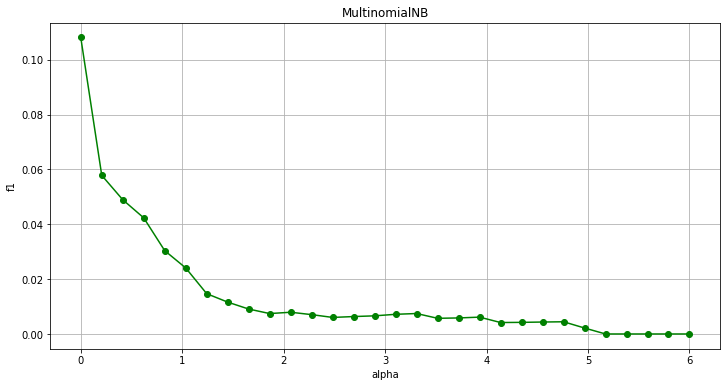

In [23]:
grid_plot(grid['alpha'], gs.cv_results_['mean_test_score'], 'alpha', 'MultinomialNB')

In [24]:
from sklearn.metrics import classification_report

clf = MultinomialNB(0)
clf.fit(X_train, y_train)

preds = clf.predict(X_test)

print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     36583
           1       0.09      0.33      0.14       195

    accuracy                           0.98     36778
   macro avg       0.54      0.65      0.56     36778
weighted avg       0.99      0.98      0.98     36778



D:\conda\lib\site-packages\sklearn\naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[[35908   675]
 [  131    64]]


Text(0.5, 42.0, 'Predicted value')

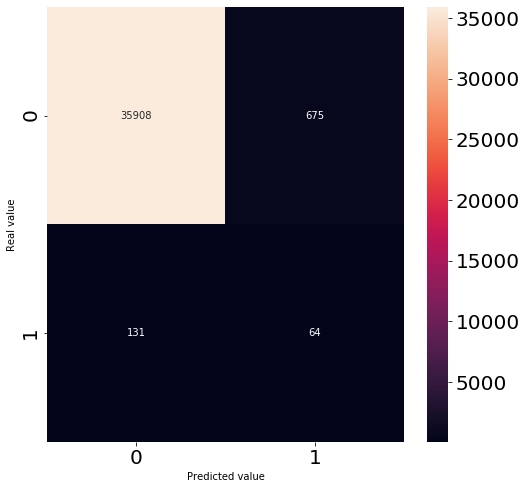

In [25]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib

fig = plt.figure(figsize=(8,8))
nn_mtx = confusion_matrix(y_test, preds)
print(nn_mtx)
font = {'weight' : 'bold', 'size'   :22}
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
sns.heatmap(nn_mtx, annot=True, fmt="d")
plt.ylabel("Real value")
plt.xlabel("Predicted value")

Алгоритм очень плохо отличает один класс, так же в приницпе плохо его обнаруживает, так как данные очень несбалансированны. Много ошибок второго рода. 

Имеет смысл попробовать ComplementNB, так как он лучше работает с несбалансированными данными

### Complement Naive Bayes

In [26]:
from sklearn.naive_bayes import ComplementNB

alg = ComplementNB()

grid = {'alpha': np.array(np.linspace(0, 6, 30), dtype='float'),
        }

gs = GridSearchCV(alg, grid, verbose=2, n_jobs = -1,scoring='f1')
gs.fit(X_train, y_train)
gs.best_params_, gs.best_score_

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    6.6s finished
D:\conda\lib\site-packages\sklearn\naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


({'alpha': 0.0}, 0.08364676128432466)

In [27]:
clf = ComplementNB(0)
clf.fit(X_train, y_train)

preds = clf.predict(X_test)

print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98     36583
           1       0.06      0.36      0.10       195

    accuracy                           0.97     36778
   macro avg       0.53      0.67      0.54     36778
weighted avg       0.99      0.97      0.98     36778



D:\conda\lib\site-packages\sklearn\naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[[35494  1089]
 [  124    71]]


Text(0.5, 42.0, 'Predicted value')

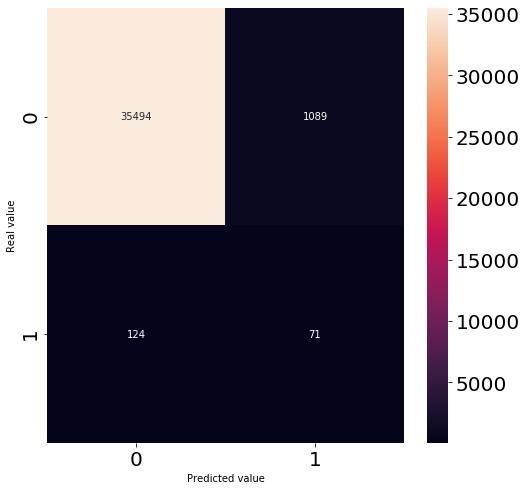

In [28]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib

fig = plt.figure(figsize=(8,8))
nn_mtx = confusion_matrix(y_test, preds)
print(nn_mtx)
font = {'weight' : 'bold', 'size'   :22}
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
sns.heatmap(nn_mtx, annot=True, fmt="d")
plt.ylabel("Real value")
plt.xlabel("Predicted value")

Данные очень несблансированны, Complement Naive Bayes стал ещё хуже отличать один из классов, хотя он лучше работает с несбалансированными данными. Ещё больше ошибок второго рода. 

Однако ошибок первого рода стало меньше, recall больше, то есть этот алгоритм лучше обнаруживает класс 1

Тут нужно решить, что ценнее, по мне, лучше совершать меньше ошибок первого рода, лучше находить 18+ тэг

В этом случае алгоритм Complement Naive Bayes справился лучше

По сравнению с tfidf представлением, bag of words сработал совсем немного хуже, хотя я ожидал, что метрики будут сильно отличаться


## Logistic Regression

In [29]:
from sklearn.linear_model import LogisticRegression

alg = LogisticRegression(class_weight='balanced')

grid = {'penalty': ['l1', 'l2', 'elasticnet'],
        'C': np.array(np.logspace(-3, 2, num = 10), dtype='float'),
        }

gs = GridSearchCV(alg, grid, verbose=2, n_jobs = -1,scoring='f1')
gs.fit(X_train, y_train)

print(gs.best_params_, gs.best_score_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  4.6min finished


{'C': 0.1668100537200059, 'penalty': 'l2'} 0.324636430582989


In [30]:
clf = LogisticRegression(C= 0.1668100537200059,penalty='l2', class_weight='balanced')
clf.fit(X_train, y_train)

preds = clf.predict(X_test)

print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     36583
           1       0.25      0.53      0.34       195

    accuracy                           0.99     36778
   macro avg       0.63      0.76      0.67     36778
weighted avg       0.99      0.99      0.99     36778



[[36278   305]
 [   91   104]]


Text(0.5, 42.0, 'Predicted value')

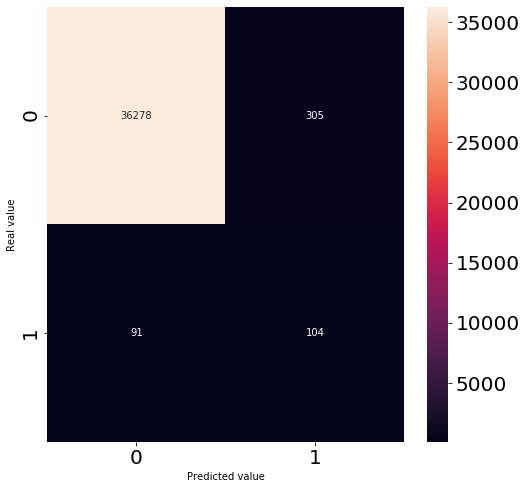

In [31]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib

fig = plt.figure(figsize=(8,8))
nn_mtx = confusion_matrix(y_test, preds)
print(nn_mtx)
font = {'weight' : 'bold', 'size'   :22}
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
sns.heatmap(nn_mtx, annot=True, fmt="d")
plt.ylabel("Real value")
plt.xlabel("Predicted value")

In [32]:
from sklearn.linear_model import LogisticRegression

alg = LogisticRegression()

grid = {'penalty': ['l1', 'l2', 'elasticnet'],
        'C': np.array(np.logspace(-3, 2, num = 10), dtype='float'),
        }

gs = GridSearchCV(alg, grid, verbose=2, n_jobs = -1,scoring='f1')
gs.fit(X_train, y_train)

print(gs.best_params_, gs.best_score_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  3.7min finished


{'C': 27.825594022071257, 'penalty': 'l2'} 0.36865645664486746


D:\conda\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [33]:
clf = LogisticRegression(C=27.825594022071257,penalty='l2')
clf.fit(X_train, y_train)

preds = clf.predict(X_test)

print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     36583
           1       0.55      0.31      0.40       195

    accuracy                           0.99     36778
   macro avg       0.77      0.66      0.70     36778
weighted avg       0.99      0.99      0.99     36778



D:\conda\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[[36533    50]
 [  134    61]]


Text(0.5, 42.0, 'Predicted value')

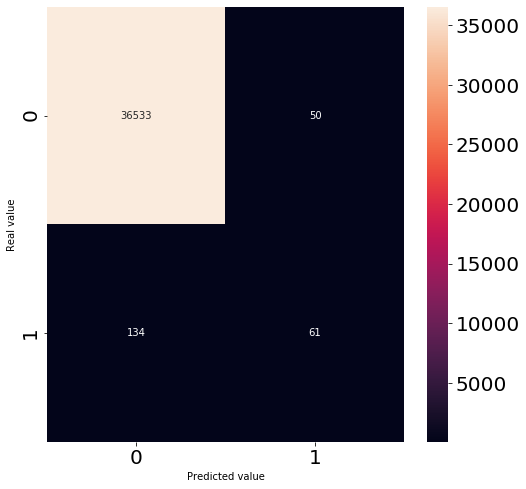

In [34]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib

fig = plt.figure(figsize=(8,8))
nn_mtx = confusion_matrix(y_test, preds)
print(nn_mtx)
font = {'weight' : 'bold', 'size'   :22}
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
sns.heatmap(nn_mtx, annot=True, fmt="d")
plt.ylabel("Real value")
plt.xlabel("Predicted value")

Я попробовал два типа логистической регрессии : со сбалансированными весами и с обычными. Если веса балансировать, то мы получаем ниже precision, но выше recall. f1 метрика остаётся прежней.

Я думаю, что лучше иметь выше reacall, чтобы в принципе лучше обнаружать класс 18+ тега. Мы совершаем меньше ошибок первого рода, но больше ошибок второго

В целом лог рег сработал сильно лучше по метрикам, чем алгоритмы Навиного Байеса

# Небольшой вывод

Больше алгоритмов обучить не получилось с таким представлением текста и таким объемом данных
В других ноутбоках я попробую bag of words и обрезать датасет

Пока из исследованного лучше всего логрег